# Installing necessary packages, can ask the users to restart the notebook

In [1]:
!pip install scikit-image PyMuPDF python-docx opencv-python scipy torch torchvision==0.2.1 pillow==8.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_c

You will be prompted to Restart the session. Continue running the cells after restarting

# Importing the necessary modules

In [53]:
# Data Pre-processing
import fitz
import cv2
import csv
import os
from docx import Document
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.utils import plot_model

# Downloading the dataset

In [2]:
# Downloading the Dataset on collab/local notebook
!gdown http://drive.google.com/uc?id=10NX_UbV2HMbPEO2fvKYAIXOOOec0g38g  # Downloading link for Ancient Text
!gdown http://drive.google.com/uc?id=1YTaqNoZCYP74AuQxlyJsiQLhcoc8DNSv  # Downloading link for Ground Truth Text

Downloading...
From: http://drive.google.com/uc?id=10NX_UbV2HMbPEO2fvKYAIXOOOec0g38g
To: /content/Padilla - Nobleza virtuosa_testExtract.pdf
100% 2.58M/2.58M [00:00<00:00, 98.2MB/s]
Downloading...
From: http://drive.google.com/uc?id=1YTaqNoZCYP74AuQxlyJsiQLhcoc8DNSv
To: /content/Padilla - 1 Nobleza virtuosa_testTranscription.docx
100% 29.1k/29.1k [00:00<00:00, 51.7MB/s]


In [3]:
response = requests.get("https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NLPRenaissanceChallenge/utils.py")
if response.status_code == 200:
    with open("utils.py", "w") as file:
        file.write(response.text)

In [4]:
!ls

'Padilla - 1 Nobleza virtuosa_testTranscription.docx'   sample_data
'Padilla - Nobleza virtuosa_testExtract.pdf'	        utils.py


# Pre-processing the dataset

### Converting PDF to images

In [5]:
from utils import pdf_to_images

pdf_path = "./Padilla - Nobleza virtuosa_testExtract.pdf"  # Path to your PDF file
output_folder = "/content/preprocessing/imgsUnProcessed"  # Output folder to save the images
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
pdf_to_images(pdf_path, output_folder)

<img src="https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NLPRenaissanceChallenge/images/imageOriginal.png">

### Splitting two sided scanned images into individual pages.

In [6]:
#Segregating 2-sided pages into individual pages
from utils import process_images

image_folder = "/content/preprocessing/imgsUnProcessed"
output_folder = "./imgsForAllPages"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
process_images(image_folder, output_folder)
print("Image processing complete!")

Image processing complete!


In [7]:
!git clone https://github.com/ML4SCI/DeepLearnHackathon.git

Cloning into 'DeepLearnHackathon'...
remote: Enumerating objects: 758, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 758 (delta 142), reused 202 (delta 122), pack-reused 509
Receiving objects: 100% (758/758), 106.48 MiB | 35.79 MiB/s, done.
Resolving deltas: 100% (416/416), done.


# Text Detection
### Extracting words from a scanned text page image can be achieved using any model of your choice. We are using the [CRAFT Model](https://github.com/clovaai/CRAFT-pytorch) for the same. (This will take 3-4 mins to process the entire model)

In [8]:
#It generally takes about ~3-4 mins
!python3 /content/DeepLearnHackathon/NLPRenaissanceChallenge/CRAFT/BoundBoxFunc/test.py --trained_model='/content/DeepLearnHackathon/NLPRenaissanceChallenge/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth'

Loading weights from checkpoint (/content/DeepLearnHackathon/NLPRenaissanceChallenge/CRAFT/BoundBoxFunc/weights/craft_mlt_25k.pth)
elapsed time : 166.18648076057434s


In [9]:
!mv /content/imgsForAllPages /content/preprocessing/imgsForAllPages

### The output of this model provides coordinates of the polygon enclosing the word. Using these coordinates one can draw a bounding box and crop word images.

In [10]:
#Sorting the BB based on the Spanish writing style
from utils import process_bounding_boxes

# Path to the directory containing text files
input_directory = "./BoundBoxApplied"
output_directory = "/content/preprocessing/BoundBoxSorted"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over each text file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_directory, filename)
        sorted_bounding_boxes = process_bounding_boxes(file_path)

        # Write sorted bounding boxes to text file in output directory
        output_file_path = os.path.join(output_directory, f"{os.path.splitext(filename)[0]}_sorted.txt")
        with open(output_file_path, "w") as outfile:
            for group in sorted_bounding_boxes:
                for box in group:
                    outfile.write(','.join(map(str, box)) + '\n')
                outfile.write((';'))

<img src="https://raw.githubusercontent.com/ML4SCI/DeepLearnHackathon/main/NLPRenaissanceChallenge/images/imageCRAFT.jpg">

### Extracting all the words from .docx file containing Transcription (True lables).

In [11]:
#ground truth to text code
from utils import save_pages_to_text

docx_file = "/content/Padilla - 1 Nobleza virtuosa_testTranscription.docx"
output_file = "/content/preprocessing/all_text.txt"     # File where the text will be saved
save_pages_to_text(docx_file, output_file)

### Since we have processed our text book into individual pages, we need to split the entire transcription based on text pages.

In [12]:
#splitting text files, based on the text
from utils import process_textfiles

textfile = '/content/preprocessing/all_text.txt'
sorted_BoundBox_folder = '/content/preprocessing/BoundBoxSorted'
output_folder = "/content/preprocessing/textSplitted"  # Replace with your output folder path
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
process_textfiles(textfile, sorted_BoundBox_folder, output_folder)
print("Text splitting complete!")

31 files in the folder
Text splitting complete!


### Extracts and saves bounding boxes from images using text data for filenames, skipping the last 6 images for testing.

In [13]:
from utils import apply_extraction_to_folder_for_train

# Example usage
image_folder = '/content/preprocessing/imgsForAllPages'
bounding_box_folder = '/content/preprocessing/BoundBoxSorted'
text_folder = '/content/preprocessing/textSplitted'
# !mkdir output
output_folder = '/content/output'
apply_extraction_to_folder_for_train(image_folder, bounding_box_folder, text_folder, output_folder)

###  Extracts and saves bounding boxes from images using a numeric counter for filenames, skipping the first 25 images.

In [14]:
from utils import apply_extraction_to_folder_for_test

# image_folder = '/content/BoundBoxApplied'
image_folder = '/content/preprocessing/imgsForAllPages'
bounding_box_folder = '/content/preprocessing/BoundBoxSorted'
word = 0
output_folder = '/content/outputTest'
apply_extraction_to_folder_for_test(image_folder, bounding_box_folder, output_folder, word)


image_26
image_27
image_28
image_29
image_30
image_31


In [21]:
def pad_and_resize_images(folder_path):
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        raise ValueError(f"The folder {folder_path} does not exist")

    # Define the target aspect ratio and size
    target_aspect_ratio = 4  # 1:4 aspect ratio
    target_width = 200
    target_height = 40

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            try:
                # Open the image
                with Image.open(file_path) as img:
                    img = img.convert('L')
                    width, height = img.size
                    aspect_ratio = width / height

                    if aspect_ratio < target_aspect_ratio:
                        # Calculate padding to make aspect ratio 1:4
                        new_width = height * 4
                        padding = (new_width - width) // 2
                        padded_img = ImageOps.expand(img, border=(padding, 0, padding, 0), fill='white')
                    else:
                        padded_img = img

                    # Resize the image to 200x40
                    resized_img = padded_img.resize((target_width, target_height))

                    # Save the processed image back to the original path
                    resized_img.save(file_path)

                    print(f"Processed and replaced: {file_path}")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

folder_path = './outputTest'
pad_and_resize_images(folder_path)

Processed and replaced: ./outputTest/60.png
Processed and replaced: ./outputTest/777.png
Processed and replaced: ./outputTest/687.png
Processed and replaced: ./outputTest/490.png
Processed and replaced: ./outputTest/816.png
Processed and replaced: ./outputTest/521.png
Processed and replaced: ./outputTest/334.png
Processed and replaced: ./outputTest/564.png
Processed and replaced: ./outputTest/642.png
Processed and replaced: ./outputTest/87.png
Processed and replaced: ./outputTest/546.png
Processed and replaced: ./outputTest/123.png
Processed and replaced: ./outputTest/797.png
Processed and replaced: ./outputTest/185.png
Processed and replaced: ./outputTest/721.png
Processed and replaced: ./outputTest/337.png
Processed and replaced: ./outputTest/89.png
Processed and replaced: ./outputTest/680.png
Processed and replaced: ./outputTest/636.png
Processed and replaced: ./outputTest/631.png
Processed and replaced: ./outputTest/695.png
Processed and replaced: ./outputTest/506.png
Processed and

# Downloading corrected dataset from drive

In [16]:
!mkdir deletedDir

In [17]:
!mv /content/output /content/deletedDir

In [18]:
!gdown https://drive.google.com/uc?id=1Gd9BWP0aixcSrs_vkDXJewd1sZEir8-m # Training data, corrrected manually
!unzip outputCorrected.zip

Downloading...
From: https://drive.google.com/uc?id=1Gd9BWP0aixcSrs_vkDXJewd1sZEir8-m
To: /content/outputCorrected.zip
100% 1.81M/1.81M [00:00<00:00, 147MB/s]
Archive:  outputCorrected.zip
   creating: outputChanged/output/
 extracting: outputChanged/output/a.png  
 extracting: outputChanged/output/abatio.png  
 extracting: outputChanged/output/abatirse.png  
 extracting: outputChanged/output/aborre.png  
 extracting: outputChanged/output/ac.png  
 extracting: outputChanged/output/acavallo.png  
 extracting: outputChanged/output/acciones.png  
 extracting: outputChanged/output/acometer.png  
 extracting: outputChanged/output/Acudireys.png  
 extracting: outputChanged/output/Acuдa.png  
  inflating: outputChanged/output/admitiendo.png  
 extracting: outputChanged/output/ador-.png  
  inflating: outputChanged/output/afeminados,.png  
 extracting: outputChanged/output/affi.png  
 extracting: outputChanged/output/afligi.png  
 extracting: outputChanged/output/afsi.png  
  inflating: output

In [19]:
!mv '/content/outputChanged/output' '/content/output'

In [22]:
# adding padding to the left and right of small sized words
folder_path = '/content/output'
pad_and_resize_images(folder_path)

Processed and replaced: /content/output/introduzirse.png
Processed and replaced: /content/output/Familias.png
Processed and replaced: /content/output/acometer.png
Processed and replaced: /content/output/buenos.png
Processed and replaced: /content/output/exercitan.png
Processed and replaced: /content/output/cobreys.png
Processed and replaced: /content/output/que (2).png
Processed and replaced: /content/output/tu.png
Processed and replaced: /content/output/virtuo-.png
Processed and replaced: /content/output/calidad.png
Processed and replaced: /content/output/conocido.png
Processed and replaced: /content/output/usan.png
Processed and replaced: /content/output/colgarle.png
Processed and replaced: /content/output/de (6).png
Processed and replaced: /content/output/no.png
Processed and replaced: /content/output/ar-.png
Processed and replaced: /content/output/profession.png
Processed and replaced: /content/output/recatada.png
Processed and replaced: /content/output/gloria.png
Processed and rep

# Image Augmentation by Rotation

In [23]:
# Define the input and output folders
input_folder = '/content/output'
output_folder = '/content/output'

# Loop through all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Open an image file
        with Image.open(os.path.join(input_folder, filename)) as img:
            # Loop from -5 to +5 degrees
            for angle in range(-5, 6):
                if(angle==0):
                    continue
                # Rotate the image
                rotated_img = img.rotate(angle, expand=True)
                # Construct the output filename
                new_filename = f"{os.path.splitext(filename)[0]}_rot{angle}{os.path.splitext(filename)[1]}"
                # Save the rotated image to the output folder
                rotated_img.save(os.path.join(output_folder, new_filename))

print("Image augmentation by Rotation completed.")

Image augmentation completed.


# Image augmentation by Gaussian Noise

In [24]:
# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, std=2):
    gauss = np.random.normal(mean, std, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image

def add_black_gaussian_noise(image, mean=0, std=25):
    gauss = np.random.normal(mean, std, image.shape).astype('int16')
    gauss = np.clip(gauss, -255, 0)  # Ensure noise is negative or zero
    noisy_image = image.astype('int16') + gauss
    noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')
    return noisy_image

input_folder = '/content/output'
output_folder = '/content/output'

# Process each image in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        noisy_img = add_black_gaussian_noise(img)
        new_filename = f"{os.path.splitext(filename)[0]}_gauss{os.path.splitext(filename)[1]}"
        output_path = os.path.join(output_folder, new_filename)
        cv2.imwrite(output_path, noisy_img)

print("Image augmentation by Gaussian Noise completed.")

Image augmentation by Gaussian Noise completed.


### Creates a CSV file listing all files in a specified folder, excluding files named ".png", with columns for the filename and its identity (name without extension).

In [25]:
from utils import create_csv_from_folder

# Train data
folder_path = "./output"  # Use raw string or double backslashes
csv_file_path = './outputs.csv'  # Use raw string or double backslashes
create_csv_from_folder(folder_path, csv_file_path)

# Test data
folder_path = "./outputTest"  # Use raw string or double backslashes
csv_file_path = './outputsTest.csv'  # Use raw string or double backslashes
create_csv_from_folder(folder_path, csv_file_path)

CSV file "./outputs.csv" created successfully.
CSV file "./outputsTest.csv" created successfully.


### Splitting train and test dataset

In [26]:
df = pd.read_csv('outputs.csv')

In [27]:
df['IDENTITY'] = df['IDENTITY'].apply(lambda x: x.split('_')[0])
df['IDENTITY'] = df['IDENTITY'].apply(lambda x: x.split(' ')[0])

In [28]:
df.shape

(26730, 2)

In [29]:
df_train = df.iloc[:20000]
df_valid = df.iloc[20001:]

In [30]:
df_train.to_csv('train.csv', index=False)
df_train.head()

,FILENAME,IDENTITY
0,el (3)_rot2_gauss.png,el
1,vuestro_rot5.png,vuestro
2,Bien_rot-5.png,Bien
3,vida_gauss.png,vida
4,introduzirse.png,introduzirse


In [31]:
df_valid.to_csv('valid.csv', index=False)
df_valid.head()

,FILENAME,IDENTITY
20001,acciones_gauss.png,acciones
20002,veo_rot-4.png,veo
20003,vida_rot3_gauss.png,vida
20004,pinas_rot3_gauss.png,pinas
20005,nua.png,nua


### This code sets up configuration parameters and file paths for training, validating, and testing an OCR model, including image size, batch size, number of epochs, model name, callbacks, learning rate, random seeds, dataset file paths, data sizes, and prefetching settings.

In [32]:
# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 200

# Model Name
MODEL_NAME = 'SpanishOCR'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_csv_path = '/content/train.csv'
valid_csv_path = '/content/valid.csv'
test_csv_path = '/content/outputsTest.csv'

train_image_dir = '/content/output'
valid_image_dir = '/content/output'
test_image_dir = '/content/outputTest'

# Data Size
# TRAIN_SIZE = BATCH_SIZE * 1000
# VALID_SIZE = BATCH_SIZE * 500
# TEST_SIZE  = BATCH_SIZE * 100


# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [33]:
# # Train CSV
# train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]

# # Validation CSV
# valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

# # Test CSV
# test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

# Train CSV
train_csv = pd.read_csv(train_csv_path)

# Validation CSV
valid_csv = pd.read_csv(valid_csv_path)

# Test CSV
test_csv = pd.read_csv(test_csv_path)

In [34]:
# In order to convert int to string to prevent tf error
test_csv['IDENTITY'] = test_csv['IDENTITY'].apply(lambda x: str(x))
# test_csv['IDENTITY'] = test_csv['IDENTITY'].apply(lambda x: x.split( ))

In [35]:
labels = [str(word) for word in df['IDENTITY'].to_numpy()]
labels[:10]

['el',
 'vuestro',
 'Bien',
 'vida',
 'introduzirse',
 'ra',
 'agradecido',
 'quita',
 'enfadados',
 'lla']

### This code extracts unique characters from the dataset labels, calculates the total number of unique characters, and prints both the count and the set of unique characters

In [36]:
# Unique characters
unique_chars = set(char for word in labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 50
Unique Characters : 
{'z', 'g', 'а', 'д', 'x', 'a', 'E', 'V', 'N', 'T', 'p', 'm', 'O', 'б', 'G', 'R', 'i', 'В', 't', ',', 'o', 'Q', 'D', 'n', 'c', 'y', 's', 'b', 'r', 'S', 'f', 'e', 'v', 'l', 'F', 'I', 'd', 'j', 'q', 'h', 'M', 'A', 'P', 'u', 'L', 'H', 'B', 'в', '-', 'C'}


In [37]:
MAX_LABEL_LENGTH = max(map(len, labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 24


### This code updates the file paths in the FILENAME columns of the training, validation, and test CSV dataframes by prepending the respective image directory paths to each filename.

In [38]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [39]:
train_csv.head()

,FILENAME,IDENTITY
0,/content/output/el (3)_rot2_gauss.png,el
1,/content/output/vuestro_rot5.png,vuestro
2,/content/output/Bien_rot-5.png,Bien
3,/content/output/vida_gauss.png,vida
4,/content/output/introduzirse.png,introduzirse


### This code creates two dictionaries: one that maps unique characters to numeric values using StringLookup, and another that reverses this mapping, converting numeric values back to characters.

In [40]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

### This function loads an image from a given path, decodes it as a JPEG, converts it to a tensor, resizes and normalizes it, and then returns the processed image as a tensor.

In [41]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies
    two processing functions: resizing and normalization. The processed image is then returned by
    the function.

    Argument :
        image_path : The path of the image file to be loaded.

    Return:
        image : The loaded image as a tensor.
    '''

    # Read the Image
    image = tf.io.read_file(image_path)

    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)

    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)

    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))

    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)

    # Return loaded image
    return image

### This function loads and preprocesses an image, converts a given label string into a sequence of numeric values, pads the numeric sequence to a fixed length, and returns a dictionary containing the processed image tensor and the label tensor.

In [42]:
def encode_single_sample(image_path : str, label : str):

    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor.
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.

    Arguments :
        image_path : The location of the image file.
        label      : The text to present in the image.

    Returns:
        dict : A dictionary containing the processed image and label.
    '''

    # Get the image
    image = load_image(image_path)

    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # Convert the characters into vectors
    vecs = char_to_num(chars)

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

### This code splits the combined dataset into training and validation subsets, shuffles the data, and then creates batched and prefetched TensorFlow datasets for efficient data loading during model training.

In [43]:
# Further split the training dataset into training and validation subsets
train_size = int(0.8*len(df))  # 80% of the training data for training
val_size = len(df) - train_size  # Remaining 20% for validation

# Splitting the training dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(df['FILENAME'].to_list()), np.array(df['IDENTITY'].to_list()))
).shuffle(train_size)

# Create training dataset
train_ds = train_ds.take(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation dataset
valid_ds = train_ds.skip(train_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)

### This code creates TensorFlow datasets for training, validation, and testing by loading image paths and labels, shuffling the training data, applying the encode_single_sample function to preprocess the images and labels, batching the data, and using prefetching for optimized data loading.

In [44]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(train_size).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# # Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# # Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [45]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 20000
Validation Data Size : 6736
Testing Data Size    : 864


### Resizes all images in the input folder to a specified size and saves them as PNG files in the output folder, ensuring the output directory exists.

In [46]:
# Set the new size in pixels (width, height) according to your choice
def resize_images_in_folder(input_folder, new_size=(200,50)):
    # Loop through all files in the input folder
    for filename in os.listdir(input_folder):
        # Open the image
        with Image.open(os.path.join(input_folder, filename)) as img:
            # Resize the image
            resized_img = img.resize(new_size)
            # Save the resized image to the output folder
            output_filename = os.path.splitext(filename)[0] + '.png'  # Ensure output format is PNG
            resized_img.save(os.path.join(output_folder, output_filename))

input_folder = "/content/output"
resize_images_in_folder(input_folder)

input_folder = "/content/outputTest"
resize_images_in_folder(input_folder)

### Displays a grid of images with their true labels, and optionally their predicted labels if a model is provided, using Matplotlib for visualization.


In [47]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):

    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

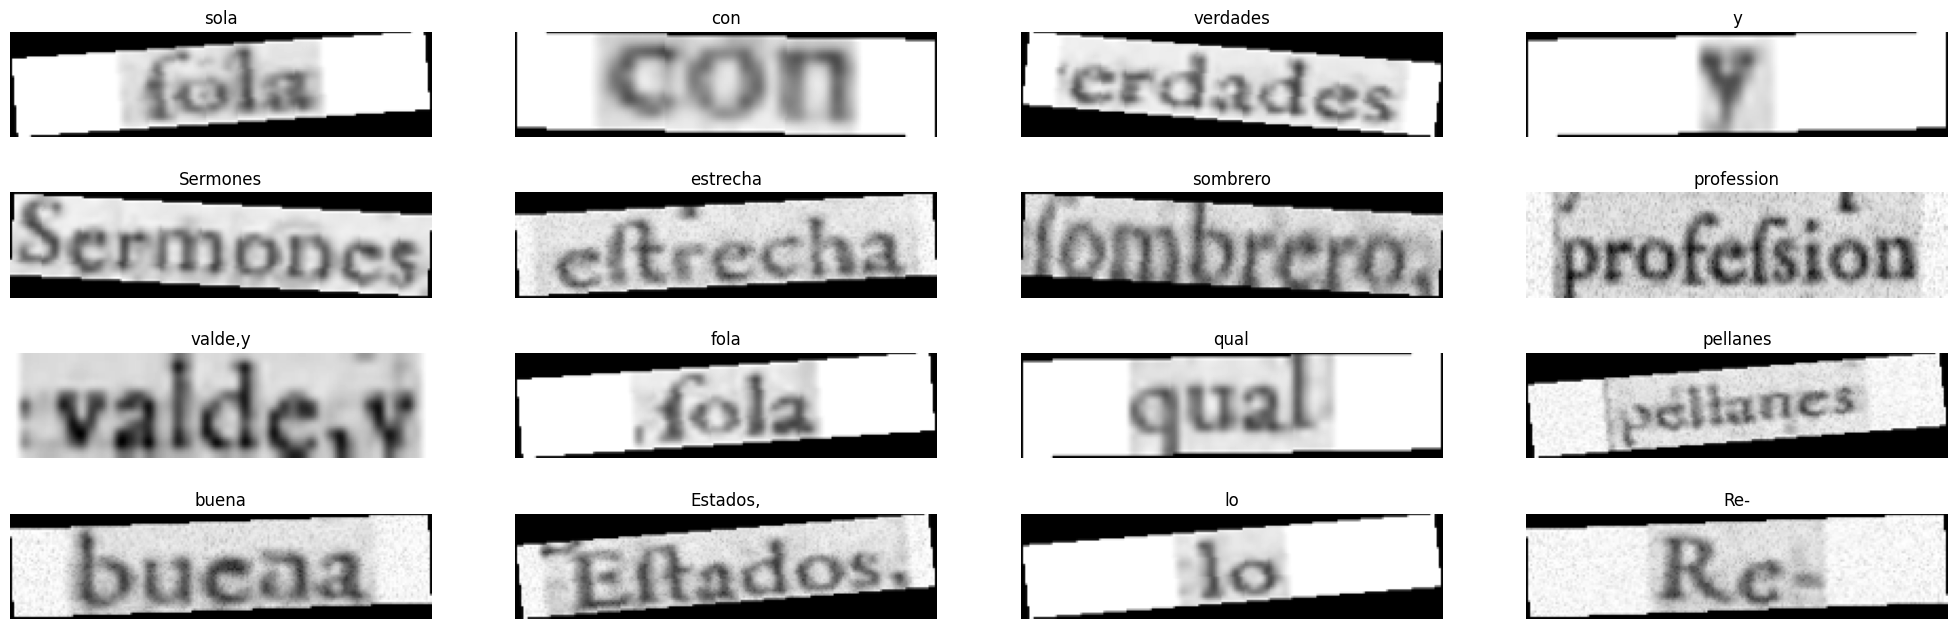

In [48]:
show_images(data=train_ds, cmap='gray')

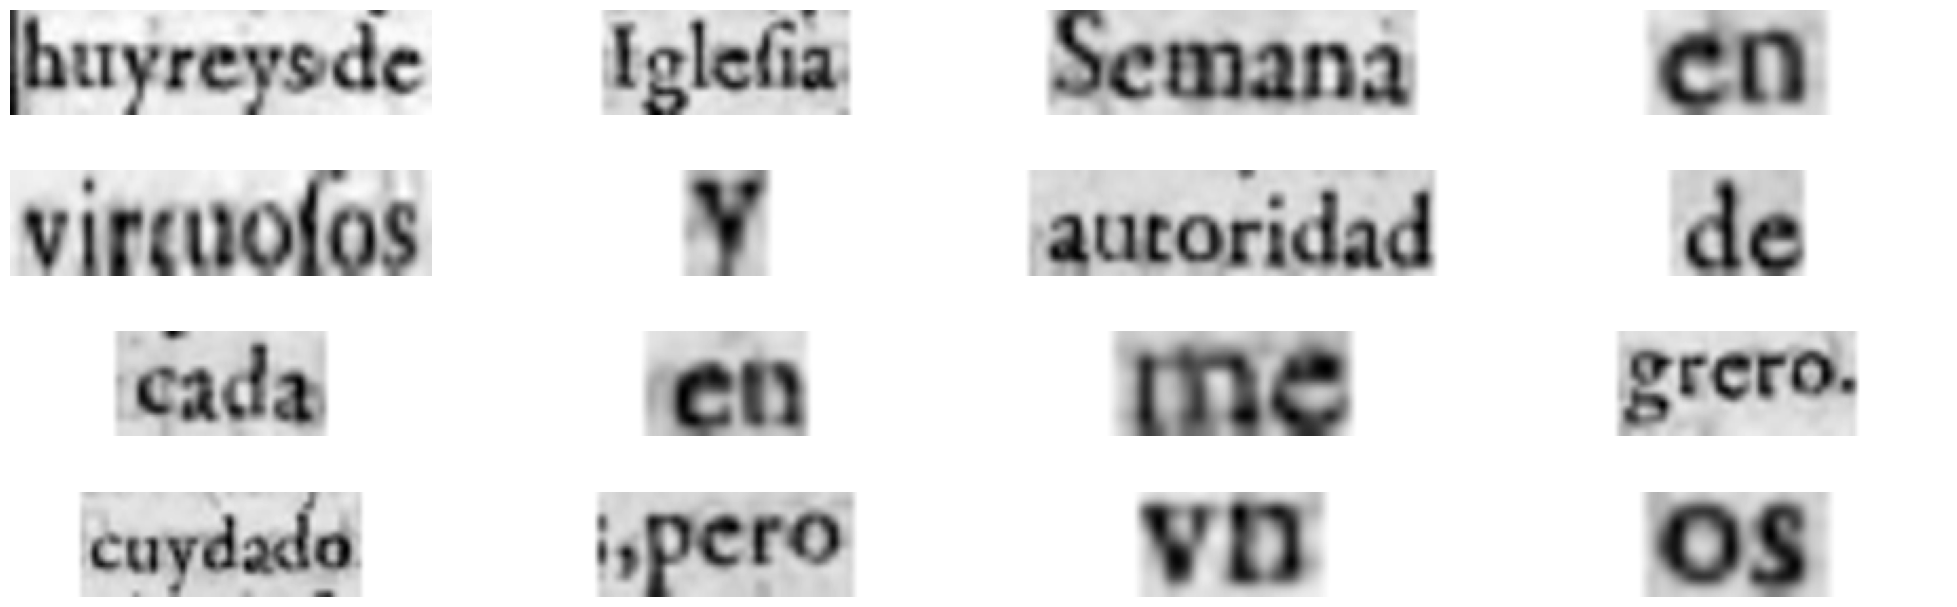

In [49]:
show_images(data=test_ds, cmap='gray')

# Model Definition

### Defines a custom Keras layer that computes and adds the Connectionist Temporal Classification (CTC) loss to the model for training sequence-to-sequence prediction tasks.

In [51]:
class CTCLayer(layers.Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        self.add_loss(loss)
        return y_pred

### Decodes the predicted labels from the OCR model, converting numeric values back to characters and removing unknown tokens to produce the final text output.

In [52]:
def decode_pred(pred_label):

    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability
    for each character. The function uses CTC decoding to decode the numeric labels back into their
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.

    Argument :
        pred_label : These are the model predictions which are needed to be decoded.

    Return:
        filtered_text : This is the list of all the decoded and processed predictions.

    '''

    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

### This code defines a deep learning model for optical character recognition (OCR) using a combination of convolutional neural networks (CNNs) for feature extraction and bidirectional long short-term memory (LSTM) networks for sequence learning, concluding with a custom CTC loss layer for training.

In [54]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*128))(x)
encoding = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.5)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.5))(encoding)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.5))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

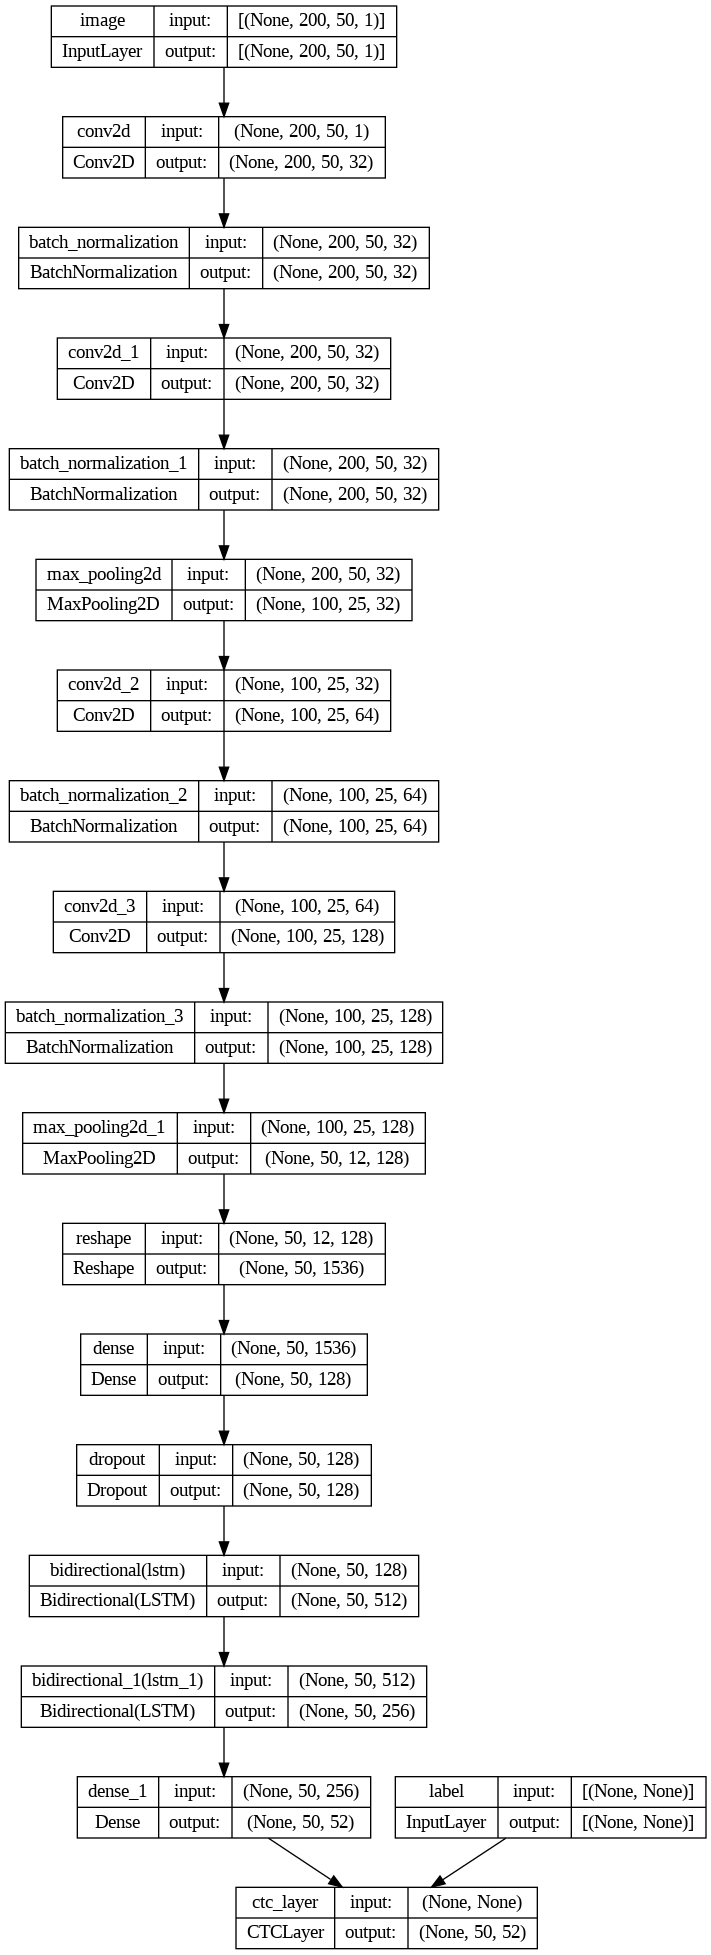

In [55]:
plot_model(ocr_model, show_shapes=True, show_layer_names=True)

### Compiles the OCR model with the Adam optimizer and trains it on the training dataset with validation, using early stopping and model checkpoint callbacks.

Epoch 1/200
1250/1250 [==============================] - 119s 76ms/step - loss: 16.0372 - val_loss: 5.1989 - lr: 0.0010
Epoch 2/200
1250/1250 [==============================] - 94s 75ms/step - loss: 3.5690 - val_loss: 1.9459 - lr: 0.0010
Epoch 3/200
1250/1250 [==============================] - 74s 59ms/step - loss: 2.0038 - val_loss: 1.2736 - lr: 0.0010
Epoch 4/200
1250/1250 [==============================] - 75s 60ms/step - loss: 1.4359 - val_loss: 0.8651 - lr: 0.0010
Epoch 5/200
1250/1250 [==============================] - 82s 66ms/step - loss: 1.0724 - val_loss: 0.6135 - lr: 0.0010
Epoch 6/200
1250/1250 [==============================] - 74s 59ms/step - loss: 0.8416 - val_loss: 0.4833 - lr: 0.0010
Epoch 7/200
1250/1250 [==============================] - 74s 59ms/step - loss: 0.6679 - val_loss: 0.3138 - lr: 0.0010
Epoch 8/200
1250/1250 [==============================] - 78s 62ms/step - loss: 0.5621 - val_loss: 0.2093 - lr: 0.0010
Epoch 9/200
1250/1250 [==============================]

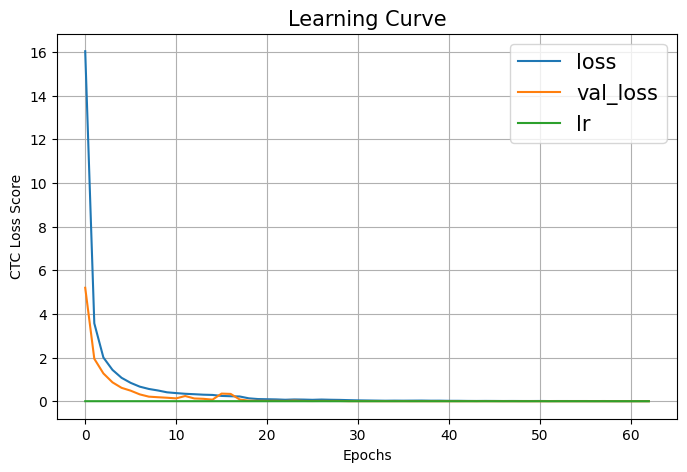

In [56]:
# Compile
ocr_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Train
history = ocr_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        lr_scheduler
    ]
)

# Learning Curve
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
# plt.savefig("OCRModel-LearningCurve.png")
plt.show()

In [57]:
# Model Summary
ocr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 200, 50, 32)          128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 200, 50, 32)          9248      ['batch_normalization[0][0

### Creates an inference model from the trained OCR model for making predictions and prints the model summary.

In [58]:
# Model required for inference
inference_model = keras.Model(
    inputs=ocr_model.get_layer(name="image").input,
    outputs=ocr_model.get_layer(name='dense_1').output
)

# Model summary
inference_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 200, 50, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 50, 32)       9248      
                                                                 
 batch_normalization_1 (Bat  (None, 200, 50, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 25, 32)       0   

In [59]:
print(decode_pred(inference_model.predict(test_ds))[:10])   #convert to test_ds

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


54/54 [==============================] - 4s 26ms/step
['huyreyde', 'Iglesia', 'Semana', 'en', 'virtuosos', 'y', 'avtoridad', 'de', 'cada', 'en']


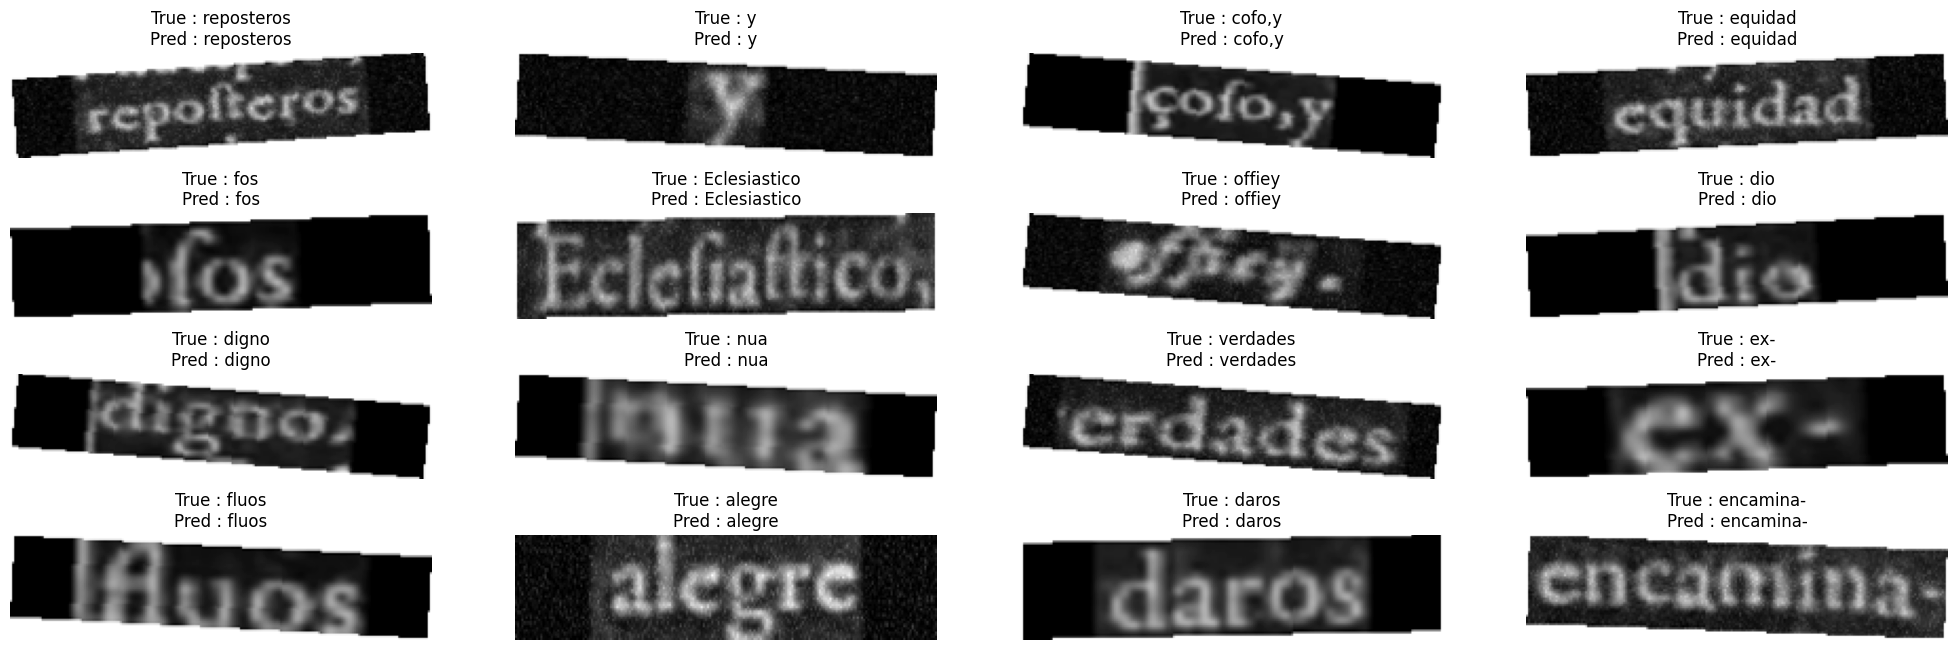

In [60]:
show_images(data=train_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

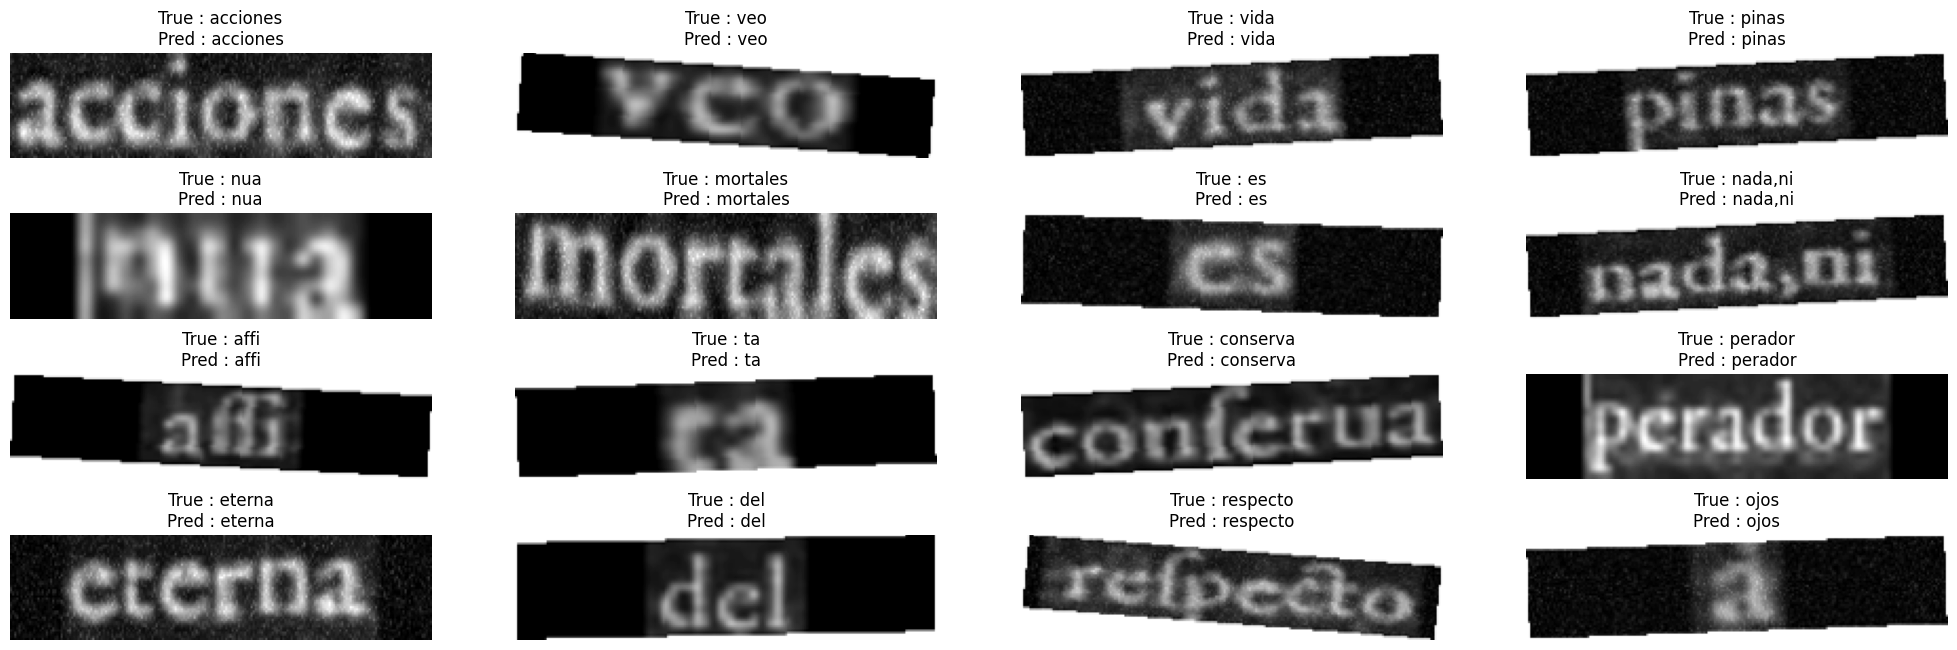

In [61]:
show_images(data=valid_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

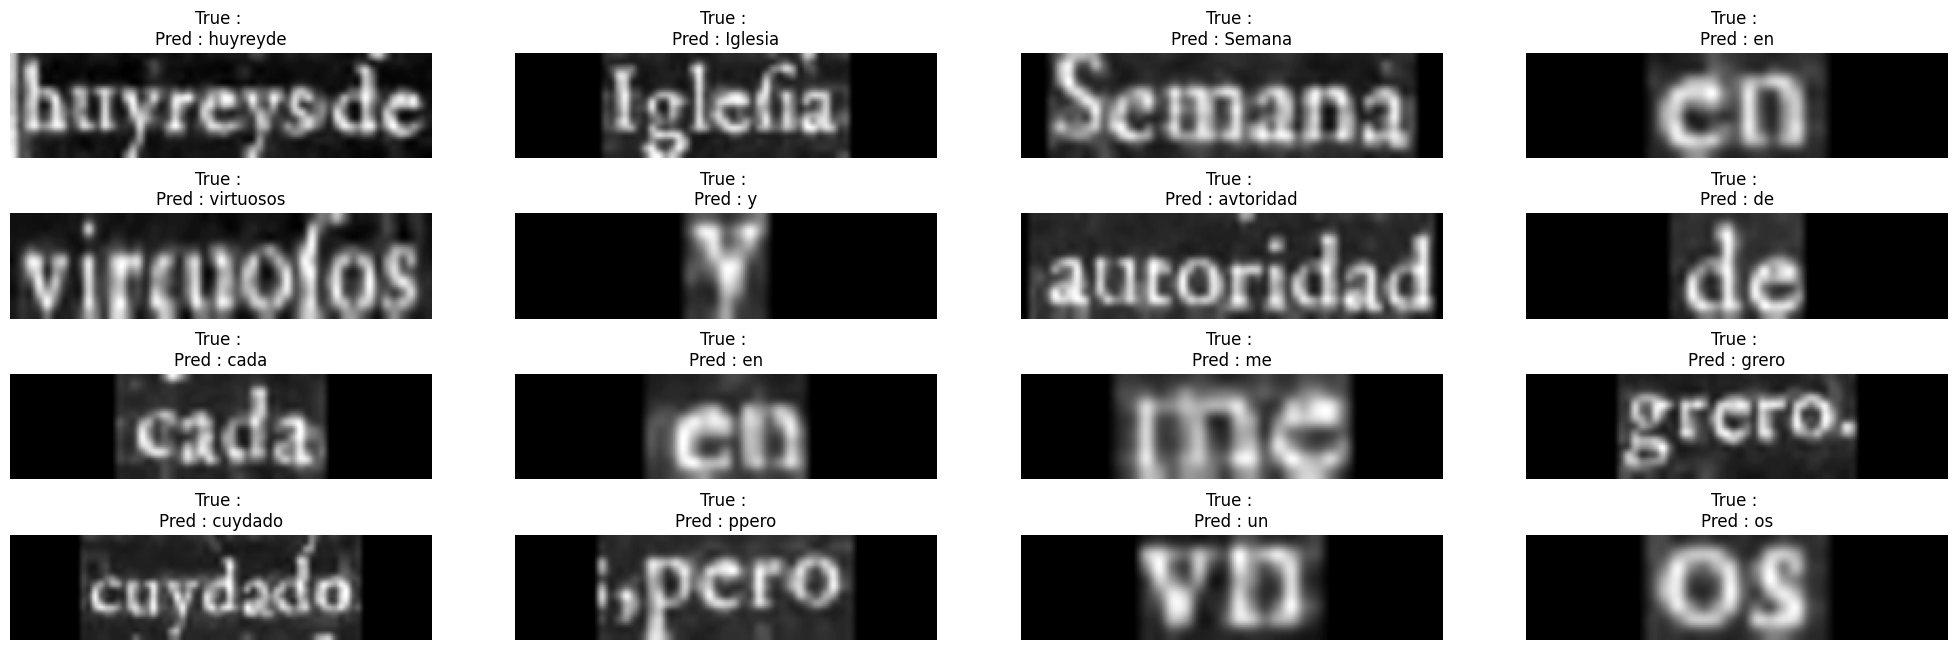

In [62]:
show_images(data=test_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

### Generates and decodes predictions from the inference model on the test dataset, printing the results in groups of 8 words per line.


In [63]:
decoded_predictions = decode_pred(inference_model.predict(test_ds))

# Print decoded predictions in groups of 8 words per line (You will have to figure out a better and ideal approach, this is just for sample)
words_per_line = 8
for i in range(0, int(len(decoded_predictions)/10), words_per_line):
    print(' '.join(decoded_predictions[i:i+words_per_line]))

54/54 [==============================] - 2s 27ms/step
huyreyde Iglesia Semana en virtuosos y avtoridad de
cada en me grero cuydado ppero un os
So otro Emperador de Christiano ha todo estima
es muy sale ella las criado poner Suaresma
seays Art dadle pues Temglanc,Obn llnira pena de-
fu partes infinitas y estacau las los tend
muy della adornado,y suietose ord tido, anticipar y
Temlaca,Obn que sean almo- oni atodas semblante ftra
por ay tormento noche quantas mortal no hazed
segura en nб no con cosas todos Reyes,
diencia nes que no el despuВs de venir,
